# Creating a Spam and Not Spam Classifier with PyTorch

Used Kaggle Dataset : https://www.kaggle.com/ozlerhakan/spam-or-not-spam-dataset

In [190]:
import torch
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

## Reading Data

In [2]:
data = pd.read_csv('spam_or_not_spam.csv')
data.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


## Preprocessing Data

#### Changing lables for ease of understanding

In [3]:
data.dropna(inplace=True)
change_labels = lambda x: 1 if x==0 else 0
data['label'] = data['label'].apply(change_labels)
data.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,1
1,martin a posted tassos papadopoulos the greek ...,1
2,man threatens explosion in moscow thursday aug...,1
3,klez the virus that won t die already the most...,1
4,in adding cream to spaghetti carbonara which ...,1


#### Let's Preprocess text data
* We will remove non words, lower it, then Tokenize, Lemmatize and Vectorize and Remove Stopwords from the data

In [4]:
remove_non_alphabets =lambda x: re.sub(r'[^a-zA-Z]',' ',x)

In [5]:
tokenize = lambda x: word_tokenize(x)

In [6]:
ps = PorterStemmer()
stem = lambda w: [ ps.stem(x) for x in w ]

In [7]:
lemmatizer = WordNetLemmatizer()
leammtizer = lambda x: [ lemmatizer.lemmatize(word) for word in x ]

In [8]:
print('Processing : [=', end='')
data['email'] = data['email'].apply(remove_non_alphabets)
print('=', end='')
data['email'] = data['email'].apply(tokenize) # [ word_tokenize(row) for row in data['email']]
print('=', end='')
data['email'] = data['email'].apply(stem)
print('=', end='')
data['email'] = data['email'].apply(leammtizer)
print('=', end='')
data['email'] = data['email'].apply(lambda x: ' '.join(x))
print('] : Completed', end='')
data.head()

Processing : [=====] : Completed

,email,label
0,date wed number aug number number number numbe...,1
1,martin a post tasso papadopoulo the greek scul...,1
2,man threaten explos in moscow thursday august ...,1
3,klez the viru that won t die alreadi the most ...,1
4,in ad cream to spaghetti carbonara which ha th...,1


In [9]:
max_words = 10000
cv = CountVectorizer(max_features=max_words, stop_words='english')
sparse_matrix = cv.fit_transform(data['email']).toarray()

In [10]:
sparse_matrix.shape

(2999, 10000)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(sparse_matrix, np.array(data['label']))

In [12]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear1 = nn.Linear(10000, 100)
        self.linear2 = nn.Linear(100, 10)
        self.linear3 = nn.Linear(10, 2)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [113]:
# model = LogisticRegression()

In [ ]:
weights #  Regularized weights
weights_unregularized # Unregularized weights
weights_l1

In [193]:
weights_l1 = []
lambdas = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 2, 3, 4]
for l in lambdas:  #[0 for _ in range(len(lambdas))]:
    model = LogisticRegression()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters() , lr=0.01, )
    epochs = 20
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train) + l * (t.norm(model.linear1.weight, 1) + t.norm(model.linear2.weight, 1) + t.norm(model.linear3.weight, 1))
        pred = torch.max(y_pred, 1)[1].eq(y_train).sum()
        acc = pred * 100.0 / len(x_train)
        loss.backward()
        optimizer.step()
    print(l)
    weights_l1.append(get_weights(model.named_parameters()))


1e-07
1e-06
1e-05
0.0001
0.001
0.01
0.1
1
2
3
4


In [200]:
len(weights[0])

1001020

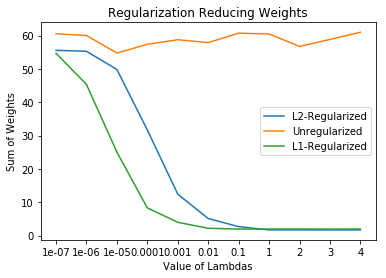

In [194]:
plt.title('Regularization Reducing Weights')
plt.xlabel('Value of Lambdas')
plt.ylabel('Sum of Weights')
plt.plot(['1e-07', '1e-06', '1e-05', '0.0001', '0.001', '0.01', '0.1', '1', '2', '3', '4'], [np.linalg.norm(x) for x in weights])
plt.plot(['1e-07', '1e-06', '1e-05', '0.0001', '0.001', '0.01', '0.1', '1', '2', '3', '4'], [np.linalg.norm(x) for x in weights_unregularized])
plt.plot(['1e-07', '1e-06', '1e-05', '0.0001', '0.001', '0.01', '0.1', '1', '2', '3', '4'], [np.linalg.norm(x) for x in weights_l1])
plt.legend(['L2-Regularized', 'Unregularized', 'L1-Regularized'])
plt.show()

In [115]:
# x_train = Variable(torch.from_numpy(x_train)).float()
# y_train = Variable(torch.from_numpy(y_train)).long()

In [201]:
index = np.random.choice(len(weights[0]), 10, replace=False)
weights_100 = [X[index] for X in weights ]
unreg_100 = [X[index] for X in weights_unregularized ]
l1_weight_100 = [X[index] for X in weights_l1]

In [202]:
w = np.array(weights_100)
w.shape

(11, 10)

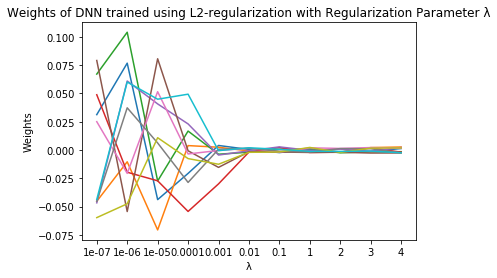

In [203]:
plt.title('Weights of DNN trained using L2-regularization with Regularization Parameter λ')
plt.xlabel('λ')
plt.ylabel('Weights')
plt.plot(['1e-07', '1e-06', '1e-05', '0.0001', '0.001', '0.01', '0.1', '1', '2', '3', '4'], weights_100)
plt.show()

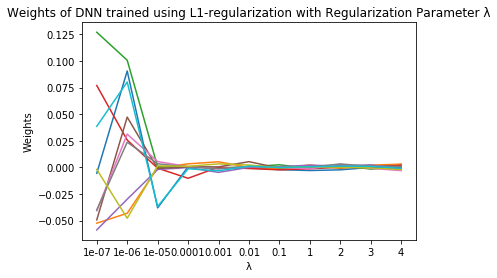

In [204]:
plt.title('Weights of DNN trained using L1-regularization with Regularization Parameter λ')
plt.xlabel('λ')
plt.ylabel('Weights')
plt.plot(['1e-07', '1e-06', '1e-05', '0.0001', '0.001', '0.01', '0.1', '1', '2', '3', '4'], l1_weight_100)
plt.show()

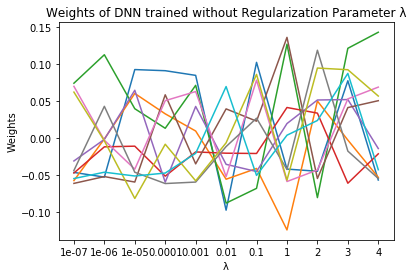

In [205]:
plt.title('Weights of DNN trained without Regularization Parameter λ')
plt.xlabel('λ')
plt.ylabel('Weights')
plt.plot(['1e-07', '1e-06', '1e-05', '0.0001', '0.001', '0.01', '0.1', '1', '2', '3', '4'], unreg_100)
plt.show()

In [116]:
def get_weights(parameters):
    weights = []
    for name, param in parameters:
        if param.requires_grad and 'weight' in name:
            weights.append([value.numpy() for value in param.data])
    weights = np.array(weights)
    weights_1 = []
    for epochweight in weights:
        for epoch in epochweight:
            for layerweight in epoch:
                weights_1.append(layerweight)
    
    return np.array(weights_1)

In [117]:
epochs = 50
model.train()
weights = [get_weights(model.named_parameters())]

for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    pred = torch.max(y_pred, 1)[1].eq(y_train).sum()
    acc = pred * 100.0 / len(x_train)
    print('Epoch: {}, Loss: {}, Accuracy: {}'.format(epoch+1, loss.item(), acc.numpy()))
    loss.backward()
    optimizer.step()
    weights.append(get_weights(model.named_parameters()))


Epoch: 1, Loss: 0.7318729758262634, Accuracy: 17
Epoch: 2, Loss: 0.6134938597679138, Accuracy: 86
Epoch: 3, Loss: 0.4569210708141327, Accuracy: 87
Epoch: 4, Loss: 0.34108221530914307, Accuracy: 90
Epoch: 5, Loss: 0.25606268644332886, Accuracy: 92
Epoch: 6, Loss: 0.1976788341999054, Accuracy: 96
Epoch: 7, Loss: 0.15793293714523315, Accuracy: 97
Epoch: 8, Loss: 0.12696358561515808, Accuracy: 98
Epoch: 9, Loss: 0.0998174250125885, Accuracy: 98
Epoch: 10, Loss: 0.0757410004734993, Accuracy: 99
Epoch: 11, Loss: 0.055164311081171036, Accuracy: 99
Epoch: 12, Loss: 0.038982193917036057, Accuracy: 99
Epoch: 13, Loss: 0.027610642835497856, Accuracy: 99
Epoch: 14, Loss: 0.02035086788237095, Accuracy: 99
Epoch: 15, Loss: 0.015877394005656242, Accuracy: 99
Epoch: 16, Loss: 0.012922357767820358, Accuracy: 99
Epoch: 17, Loss: 0.01075657643377781, Accuracy: 99
Epoch: 18, Loss: 0.009006003849208355, Accuracy: 99
Epoch: 19, Loss: 0.007501745596528053, Accuracy: 99
Epoch: 20, Loss: 0.00617213686928153, A

In [118]:
index = np.random.choice(len(weights[0]), 100, replace=False)
modified_weights = [X[index] for X in weights ]

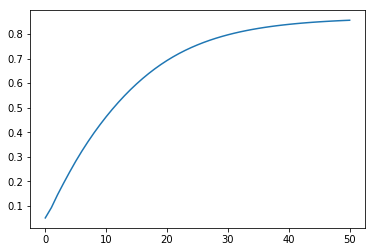

In [122]:
plt.plot([i for i in range(epochs+1)], [np.linalg.norm(x) for x in modified_weights])
plt.show()

# Testing

In [18]:
x_test = Variable(torch.from_numpy(x_test)).float()
y_test = Variable(torch.from_numpy(y_test)).long()

In [19]:
model.eval()
with torch.no_grad():
    y_pred = model(x_test)
    loss = criterion(y_pred, y_test)
    pred = torch.max(y_pred, 1)[1].eq(y_test).sum()
    print ("Accuracy : {}%".format(100*pred/len(x_test)))


Accuracy : 99%
